In [2]:
### Figure 2J Population Correlation

import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import helperFunc




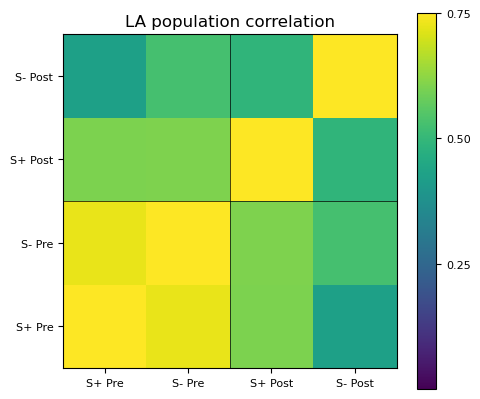

Saved figure for LA -> C:\Users\Cristina\Documents\GitHub\BLAPIRpaper\Figure2J\PopulationCorrelation_experiment1_LA.png


<Figure size 640x480 with 0 Axes>

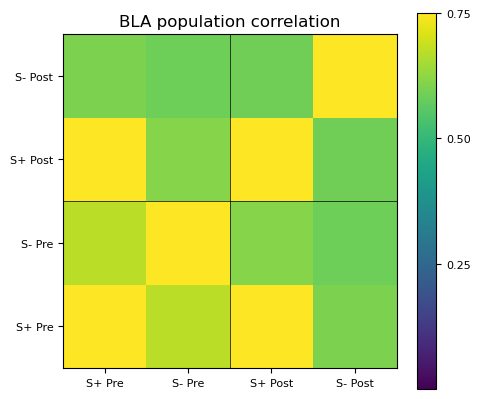

Saved figure for BLA -> C:\Users\Cristina\Documents\GitHub\BLAPIRpaper\Figure2J\PopulationCorrelation_experiment1_BLA.png


<Figure size 640x480 with 0 Axes>

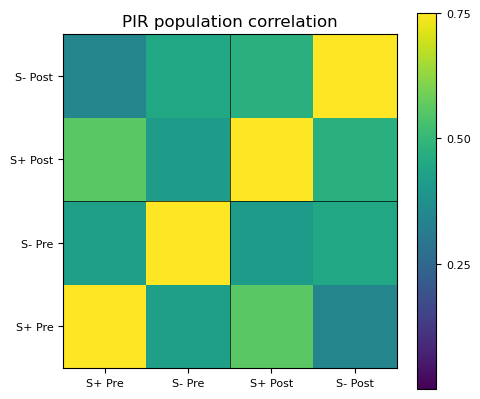

Saved figure for PIR -> C:\Users\Cristina\Documents\GitHub\BLAPIRpaper\Figure2J\PopulationCorrelation_experiment1_PIR.png


<Figure size 640x480 with 0 Axes>

In [6]:

# ============================================================
# Helper function: Compute ROC over sliding 2-bin windows
# ============================================================
def roctimewarp(data):
    """
    Compute a time-warped ROC for each neuron across time.

    Parameters
    ----------
    data : ndarray
        Shape (neurons, timebins). Each row = one neuron.

    Returns
    -------
    rocdata : ndarray
        Shape (neurons, timebins-2). NaNs replaced with 0.5.
    """
    basefr = data[:, :5]  # first 5 bins as baseline
    rocdata = np.zeros((data.shape[0], data.shape[1] - 2))

    for n in range(data.shape[0]):
        for t in range(data.shape[1] - 2):
            roc_val = helperFunc.calcROC(basefr[n, :], data[n, t:t + 2])[0]
            rocdata[n, t] = roc_val

    rocdata[np.isnan(rocdata)] = 0.5  # replace NaNs with chance level
    return rocdata


# ============================================================
# Paths & setup
# ============================================================
cwd = Path.cwd()
outdir = cwd / "Figure2J"
outdir.mkdir(exist_ok=True)

# Input files (must be in current directory or adjust paths here)
masterlist_path = cwd / "masterlist_experiment1task.csv"
prelearning_path = cwd / "data_timewarped/prelearning.npy"
postlearning_path = cwd / "data_timewarped/postlearning.npy"
preresponsive_path = cwd / "Figure2F/prelearning_responsivesensory.npy"
postresponsive_path = cwd / "Figure2F/postlearning_responsivesensory.npy"

# Load master list and datasets
masterlist = np.loadtxt(masterlist_path, delimiter=",", dtype=str)
prelearning = np.load(prelearning_path)
postlearning = np.load(postlearning_path)
preresponsive = np.load(preresponsive_path)
postresponsive = np.load(postresponsive_path)

# Determine responsive neurons
allresponsive = np.hstack((preresponsive, postresponsive))
responsiveidx = np.where(np.sum(allresponsive, axis=1) > 0)[0]


# ============================================================
# Analysis parameters
# ============================================================
areas = ['LA', 'BLA', 'PIR']  # edit if needed
savename = "experiment1"


# ============================================================
# Main loop: process each brain area
# ============================================================
for area in areas:
    # Select neurons in area
    neuronidx = np.where(masterlist[:, 2] == area)[0]
    neuronidx = np.intersect1d(neuronidx, responsiveidx)

    if neuronidx.size == 0:
        print(f"[WARN] No neurons found for area {area}, skipping.")
        continue

    # Split conditions: 0 = S+ (reward), 1 = S- (unreward)
    rewardpre = prelearning[neuronidx, :, 0]
    unrewardpre = prelearning[neuronidx, :, 1]
    rewardpost = postlearning[neuronidx, :, 0]
    unrewardpost = postlearning[neuronidx, :, 1]

    # Compute ROC time series
    rewardrocpre = roctimewarp(rewardpre)
    unrewardrocpre = roctimewarp(unrewardpre)
    rewardrocpost = roctimewarp(rewardpost)
    unrewardrocpost = roctimewarp(unrewardpost)

    # Stack all conditions
    learningmatrix = np.dstack((
        rewardrocpre,
        unrewardrocpre,
        rewardrocpost,
        unrewardrocpost
    ))

    # Peak sensory period (time bins 13–16 inclusive)
    learningmatrix = np.mean(learningmatrix[:, 13:17, :], axis=1)

    # ========================================================
    # Plot correlation matrix
    # ========================================================
    fig, ax = plt.subplots(1, figsize=(5, 5))
    corr_matrix = np.corrcoef(learningmatrix.T)

    im = ax.imshow(corr_matrix, cmap="viridis", vmin=0, vmax=0.75)
    ax.set_title(f"{area} population correlation")
    ax.set_ylim(-0.5, 3.5)
    ax.set_xticks((0, 1, 2, 3))
    ax.set_yticks((0, 1, 2, 3))
    ax.set_xticklabels(['S+ Pre', 'S- Pre', 'S+ Post', 'S- Post'], fontsize=8)
    ax.set_yticklabels(['S+ Pre', 'S- Pre', 'S+ Post', 'S- Post'], fontsize=8)
    ax.vlines(1.5, -0.5, 3.5, color='black', linewidth=0.5)
    ax.hlines(1.5, -0.5, 3.5, color='black', linewidth=0.5)

    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_ticks([0.25, 0.5, 0.75])
    cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()

    plt.show()
    outfile = outdir / f"PopulationCorrelation_{savename}_{area}.png"
    
    plt.savefig(outfile, dpi=300)
    plt.close(fig)

    print(f"Saved figure for {area} -> {outfile}")
